In [1]:
import dataloader
import random
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import torch

In [2]:
raw_dataset = dataloader.get_dataset(None, 8192)
print({ k: len(v) for k, v in raw_dataset.items() })

{'Whistling': 22, 'BackgroundSounds': 8192, 'Horn': 1146, 'Train': 895, 'Clapping': 546, 'Laughing': 216, 'Whistle': 21, 'Dog': 2768, 'Noise': 1950, 'Rooster': 402, 'BirdChirp': 1299, 'Sneezing': 154, 'Aircraft': 1119, 'Siren': 2363, 'Scream': 36, 'Crow': 621, 'Gunshot': 8, 'Wind': 1408, 'Frog': 3608, 'CarDoor': 452, 'Engine': 5845, 'VehicleExhaust': 292, 'Coughing': 736, 'Cat': 242, 'Bell': 702, 'Beeping': 98, 'Thunder': 488, 'Unknown': 293, 'Insects': 1986, 'Sheep': 191, 'Basketball': 752, 'Drums': 6193, 'Cow': 168, 'GunNoise': 2448, 'PowerTool': 1537, 'GlassBreak': 982, 'Skateboarding': 76, 'Jackhammer': 2882, 'HandSaw': 332}


8.5208175732987e-06


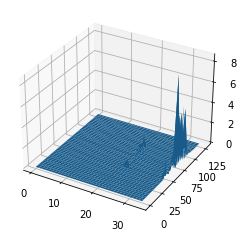

new point [82, 33, 3.1393767130794004e-05]
5.063285698270192e-06


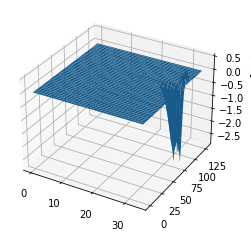

new point [93, 33, 1.631468148843851e-05]
4.1361099647474475e-06


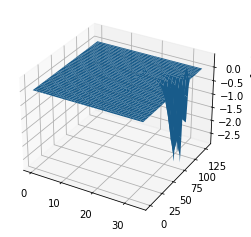

new point [103, 33, 5.7130559980578255e-06]
2.982663772854721e-06


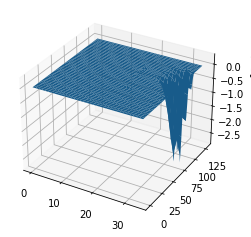

new point [49, 34, 4.646848992706509e-06]
2.982663772854721e-06


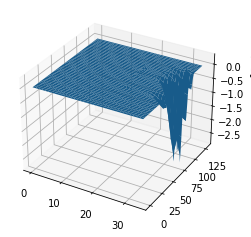

new point [66, 34, 3.2586999623163138e-06]
2.982663772854721e-06


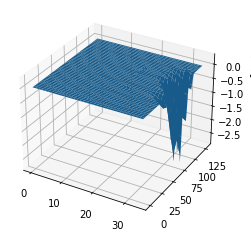

new point [91, 21, 3.0640287604910554e-06]
2.982663772854721e-06


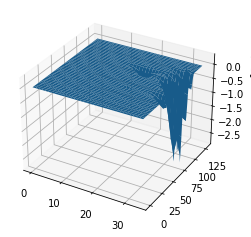

new point [81, 21, 1.7046290849975776e-06]
2.982663772854721e-06


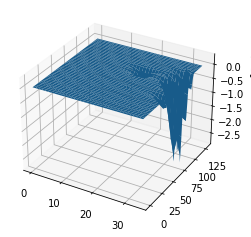

new point [48, 22, 1.670563392508484e-06]
2.982663772854721e-06


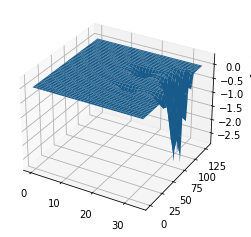

array([[8.20000000e+01, 3.30000000e+01, 3.13937671e-05],
       [9.30000000e+01, 3.30000000e+01, 1.63146815e-05],
       [1.03000000e+02, 3.30000000e+01, 5.71305600e-06],
       [4.90000000e+01, 3.40000000e+01, 4.64684899e-06],
       [6.60000000e+01, 3.40000000e+01, 3.25869996e-06],
       [9.10000000e+01, 2.10000000e+01, 3.06402876e-06],
       [8.10000000e+01, 2.10000000e+01, 1.70462908e-06],
       [4.80000000e+01, 2.20000000e+01, 1.67056339e-06]])

In [62]:
def get_spectrum(sample):
    assert sample.shape == (8000,)

    sample_offset = np.mean(sample)
    sample = sample - sample_offset

    sample_scale = np.sqrt(np.sum(sample**2))
    if sample_scale <= 0:
        sample_scale = 1
    sample = sample / sample_scale

    f, t, Sxx = sig.spectrogram(sample, dataloader.UNIFORM_SAMPLE_RATE)
    return Sxx, (sample_scale, sample_offset)

sample = random.choice(raw_dataset['BirdChirp'])
spectrum, spectrum_params = get_spectrum(sample)

def plot3d(spectrum):
    assert len(spectrum.shape) == 2
    fig = plt.figure()
    p = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(spectrum.shape[1]), range(spectrum.shape[0]))
    p.plot_surface(x, y, spectrum)
    plt.show()

def decompose_gaussians(spectrum, variances, *, log = False):
    assert len(spectrum.shape) == 2
    spectrum = torch.tensor(spectrum).cuda()
    
    res = []

    if log:
        print(torch.max(spectrum).item())
        plot3d(np.array(spectrum.cpu()))

    for variance in variances:
        r = [min(2 * variance, dim - 1) for dim in spectrum.shape]
        x, y = torch.meshgrid(torch.tensor(range(-r[0], r[0] + 1)).cuda(), torch.tensor(range(-r[1], r[1] + 1)).cuda())
        g = torch.exp(-(x**2 + y**2) / variance)
        e = torch.nn.functional.conv2d(spectrum.reshape(1, 1, *spectrum.shape), g.reshape(1, 1, *g.shape), padding = 'same').reshape(spectrum.shape)
        assert spectrum.shape == e.shape, f'{spectrum.shape} -> {e.shape}'
        p = np.unravel_index(torch.argmax(e).item(), e.shape)
        assert len(p) == 2, f'{p}'
        m = e[p]
        res.append([*p, m.item()])
        x, y = torch.meshgrid(torch.tensor(range(spectrum.shape[0])).cuda(), torch.tensor(range(spectrum.shape[1])).cuda())
        assert x.shape == y.shape == spectrum.shape
        spectrum = spectrum - m * torch.exp(-((x-p[0])**2 + (y-p[1])**2) / variance)
        
        if log:
            print('new point', res[-1])
            print(torch.max(spectrum).item())
            plot3d(np.array(spectrum.cpu()))

    return np.array(res)

decompose_gaussians(spectrum, [10] * 8, log = True)